# Comparison Figures — EMDAT Geocoding Validation

This notebook generates comparison figures to evaluate geocoded event geometries against reference benchmarks. It:
- Loads validation outputs produced by the pipeline (`output/` CSV files following a strict naming convention)
- Merges metadata from the EMDAT archive (year, region, disaster type)
- Produces histograms and summary bar charts (by region, year, and disaster type)

Requirements:
- `config.toml` must define paths: `path.validation_output_dir` and `path.emdat_archive_path`.
- Validation outputs must be present in the `output/` directory and follow the expected filename pattern.

In [1]:
import re
import tomllib
from pathlib import Path
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

import seaborn as sns

from validation.io import load_emdat_archive

with open('config.toml', 'rb') as f:
    config = tomllib.load(f)

## Plot styling
Standardized Matplotlib and Seaborn styling for consistent figures in the paper/report.


In [2]:
MPL_CONFIG = {
    "font.family": "Arial",
    "font.size": "8",
    "axes.titlesize": "6",
    "axes.labelsize": "6",
    "xtick.labelsize": "6",
    "ytick.labelsize": "6",
    "legend.fontsize": "6",
    "axes.linewidth": 1,
    "lines.linewidth": .5,
    "xtick.major.size": 3,
    "xtick.minor.size": 2,
    "ytick.major.size": 3,
    "ytick.minor.size": 2,
    "xtick.major.width": 0.5,
    "ytick.major.width": 0.5,
    "xtick.minor.width": 0.3,
    "ytick.minor.width": 0.3,
    "xtick.color": "black",
    "ytick.color": "black",
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "legend.frameon": False,
    "axes.grid": False,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.bottom": False,
}
mpl.rcParams.update(MPL_CONFIG)

## I/O and constants
Set up paths, filename pattern, and plotting bins.


In [3]:
OUTPUT_DIR = Path(config['path']['validation_output_dir'])
FILENAME_PATTERN = r'^([a-z]+_[a-z]+)_([a-z]+)_batch([1-5])(?:_dissolved)?\.csv$'
BINS = np.linspace(0, 1, 11)

## Helper functions
Filename validation and parsing utilities.


In [4]:
def validate_output_filename(
        filename: str | Path,
        filename_pattern=FILENAME_PATTERN
) -> bool:
    """Check if a filename matches the expected pattern."""
    if isinstance(filename, Path):
        filename = filename.name
    elif not isinstance(filename, str):
        raise TypeError("Filename must be a string or Path object.")
    return bool(re.match(filename_pattern, filename))


def _parse_output_filename(
        filename: str | Path,
        flexible_pattern=FILENAME_PATTERN
):
    """Parse filename using flexible regex and extract components."""
    match = re.match(flexible_pattern, filename)
    if match:
        geom_source = match.group(1)  # e.g., "llm_gadm", etc.
        benchmark = match.group(2)  # e.g., "gaul", "gdis"
        batch_number = int(match.group(3))
        dissolved = filename.endswith('_dissolved.csv')
        return geom_source, benchmark, batch_number, dissolved
    return None


def get_output_file_list(output_dir: str | Path):
    """Get a list of output files."""
    output_dir = Path(output_dir)
    output_files = [f.name for f in output_dir.glob('*.csv')]
    assert all([validate_output_filename(fn) for fn in output_files])
    return output_files


def get_output_files_metadata(output_list: list[str]):
    """Get a dataframe of output files metadata."""
    metadata = [_parse_output_filename(fn) for fn in output_list]
    return pd.DataFrame(
        index=output_list,
        columns=['geom_source', 'benchmark', 'batch_number', 'dissolved'],
        data=metadata
    )


def get_output_data(output_list: list[str],
                    output_dir: str | Path = OUTPUT_DIR):
    """Get a dataframe of output data."""
    output_data = pd.DataFrame()
    for fn in output_list:
        df_tmp = pd.read_csv(output_dir / fn)
        output_data = pd.concat([output_data, df_tmp], axis=0)
    return output_data.reset_index(drop=True)



## Load output file list and metadata
Discover available CSV outputs and parse their metadata using the filename pattern.


In [5]:
output_file_list = get_output_file_list(OUTPUT_DIR)
output_files_metadata = get_output_files_metadata(output_file_list)
output_files_metadata

,geom_source,benchmark,batch_number,dissolved
gdis_gadm_gaul_batch1.csv,gdis_gadm,gaul,1,False
gdis_gadm_gaul_batch1_dissolved.csv,gdis_gadm,gaul,1,True
gdis_gadm_gaul_batch2.csv,gdis_gadm,gaul,2,False
gdis_gadm_gaul_batch2_dissolved.csv,gdis_gadm,gaul,2,True
gdis_gadm_gaul_batch3.csv,gdis_gadm,gaul,3,False
...,...,...,...,...
llm_wiki_gdis_batch3_dissolved.csv,llm_wiki,gdis,3,True
llm_wiki_gdis_batch4.csv,llm_wiki,gdis,4,False
llm_wiki_gdis_batch4_dissolved.csv,llm_wiki,gdis,4,True
llm_wiki_gdis_batch5.csv,llm_wiki,gdis,5,False


In [6]:
file_list_dissolved = [i for i in output_file_list if "dissolved" in i]
file_list_not_dissolved = [i for i in output_file_list if "dissolved" not in i]
output_data = get_output_data(file_list_not_dissolved)
output_data_dissolved = get_output_data(file_list_dissolved)
print(f"Rows (not dissolved): {len(output_data):,}")
print(f"Rows (dissolved): {len(output_data_dissolved):,}")

Rows (not dissolved): 181,449
Rows (dissolved): 38,585


## Post-processing
- For `llm_wiki`, use `b_contains_a` as `a_in_b` to keep the metric comparable.
- Remove incomplete dissolves when the same `dis_no` appears dissolved across different batches.
- Join with EMDAT metadata and harmonize labels.

### post-processing wiki data

In [7]:
output_data.loc[
    output_data['geom_type_a'] == 'llm_wiki',
    'a_in_b'
] = output_data.loc[
    output_data['geom_type_a'] == 'llm_wiki',
    'b_contains_a'
].astype(float)

### Remove duplicates in dissolved comparative analysis

For a few and marginal number of cases, some units associated with the same
disno. were dissolved, while being dispatched in different batches.
In these cases, the dissolve was then incomplete and the resulting statistic
not relevant. Hence, we remove these cases here:

In [8]:
output_data_dissolved.drop_duplicates(
    subset=['dis_no', 'geom_type_a', 'geom_type_b'],
    keep=False,
    inplace=True
)
print(f"Rows (dissolved): {len(output_data_dissolved):,}")

Rows (dissolved): 38,555


### Merge with EMDAT metadata and harmonize labels
- Harmonize `geom_type_a` naming: replace `gdis_gadm` with `GDIS`.
- Merge EMDAT archive columns (year, region, subregion, country, disaster type) for grouping and summaries.


In [9]:
# Harmonize geom_type_a values across both DataFrames
replacements = {
    "gdis_gadm": "GDIS",
    "llm_gadm": "LLMGeoDis (GADM)",
    "llm_osm": "LLMGeoDis (OSM)",
    "llm_wiki": "LLMGeoDis (Wiki)"
}

output_data['geom_type_a'] = output_data['geom_type_a'].replace(replacements)
output_data_dissolved['geom_type_a'] = output_data_dissolved[
    'geom_type_a'].replace(replacements)


In [10]:
# Add year & region
df_emdat = load_emdat_archive(
    config["path"]["emdat_archive_path"],
    use_columns=["DisNo.", "Start Year", "Country", "Region", "Subregion",
                 "Disaster Type"]
).rename(columns={"DisNo.": "dis_no"})

output_data = pd.merge(
    output_data, df_emdat, how="left", left_on="dis_no", right_on="dis_no"
)
output_data_dissolved = pd.merge(
    output_data_dissolved,
    df_emdat,
    how="left",
    left_on="dis_no",
    right_on="dis_no"
)

In [11]:
output_data

,dis_no,name,admin_level,admin1,admin2,geom_type_a,geom_type_b,batch_number,area_calculation_method,area_a,...,jaccard,a_contains_b,b_contains_a,a_contains_b_properly,b_contains_a_properly,Start Year,Country,Region,Subregion,Disaster Type
0,2009-0631-ALB,Ana E Malit,AdminAdmin3,Shkoder,Shkodres,GDIS,GAUL,1,geodetic,4.387333e+07,...,0.054691,False,False,False,False,2009,Albania,Europe,Southern Europe,Flood
1,2009-0631-ALB,Bushat,AdminAdmin3,Shkoder,Shkodres,GDIS,GAUL,1,geodetic,5.942955e+07,...,0.069315,False,False,False,False,2009,Albania,Europe,Southern Europe,Flood
2,2001-0146-AGO,Onjiva,AdminAdmin3,Cunene,Cuanhama,GDIS,GAUL,1,geodetic,2.114110e+09,...,0.016538,False,True,False,True,2001,Angola,Africa,Sub-Saharan Africa,Flood
3,2009-0092-AGO,Evale,AdminAdmin3,Cunene,Cuanhama,GDIS,GAUL,1,geodetic,2.039397e+09,...,0.002673,False,True,False,True,2009,Angola,Africa,Sub-Saharan Africa,Flood
4,2009-0092-AGO,Mupa,AdminAdmin3,Cunene,Cuvelai,GDIS,GAUL,1,geodetic,2.166761e+09,...,0.002840,False,True,False,True,2009,Angola,Africa,Sub-Saharan Africa,Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181444,2014-0314-JPN,Kochi,Admin1,Kochi,NaN,LLMGeoDis (Wiki),GDIS,5,geodetic,0.000000e+00,...,0.000000,False,True,False,True,2014,Japan,Asia,Eastern Asia,Storm
181445,2011-0432-DMA,Canefield,Admin3,St. Paul,NaN,LLMGeoDis (Wiki),GDIS,5,geodetic,0.000000e+00,...,0.000000,False,True,False,True,2011,Dominica,Americas,Latin America and the Caribbean,Storm
181446,2011-0432-DMA,Coulibistrie,Admin3,St. Joseph,NaN,LLMGeoDis (Wiki),GDIS,5,geodetic,0.000000e+00,...,0.000000,False,True,False,True,2011,Dominica,Americas,Latin America and the Caribbean,Storm
181447,2011-0432-DMA,Mahaut,Admin3,St. Paul,NaN,LLMGeoDis (Wiki),GDIS,5,geodetic,0.000000e+00,...,0.000000,False,True,False,True,2011,Dominica,Americas,Latin America and the Caribbean,Storm


## Summary statistics
Inspect a specific source/benchmark subset and basic distribution for a spot check.

### A in B (not dissolved)

In [12]:
a_in_b_summary = output_data.groupby(['geom_type_a', 'geom_type_b'])[
    ['a_in_b']].describe(percentiles=[.1, .9])
a_in_b_summary

a_in_b                                         \
                                count      mean       std  min           10%   
geom_type_a      geom_type_b                                                   
GDIS             GAUL         28449.0  0.862102  0.307418  0.0  1.145562e-01   
LLMGeoDis (GADM) GAUL         37253.0  0.822943  0.349486  0.0  6.671116e-03   
                 GDIS         26626.0  0.717270  0.429626  0.0  1.262288e-09   
LLMGeoDis (OSM)  GAUL         38041.0  0.849775  0.278544  0.0  3.911247e-01   
                 GDIS         26949.0  0.718132  0.393355  0.0  9.792010e-05   
LLMGeoDis (Wiki) GAUL         13866.0  0.880066  0.324896  0.0  0.000000e+00   
                 GDIS         10265.0  0.760546  0.426771  0.0  0.000000e+00   

                                                       
                                   50%  90%       max  
geom_type_a      geom_type_b                           
GDIS             GAUL         0.989924  1.0  1.012442  
LLMGeoDis (GADM) GAUL         0.991900  1.0  1.000130  
                 GDIS         0.994633  1.0  1.001719  
LLMGeoDis (OSM)  GAUL         0.989953  1.0  1.000487  
                 GDIS         0.975633  1.0  1.002217  
LLMGeoDis (Wiki) GAUL         1.000000  1.0  1.000000  
                 GDIS         1.000000  1.0  1.000000

In [13]:

strictly_null_counts = output_data[output_data['a_in_b'] == 0].groupby(
    ['geom_type_a', 'geom_type_b']
).size().reset_index(name='strictly_null_count')

total_counts = output_data.groupby(
    ['geom_type_a', 'geom_type_b']).size().reset_index(name='total_count')

null_frequency = pd.merge(strictly_null_counts, total_counts,
                          on=['geom_type_a', 'geom_type_b'])
null_frequency['frequency'] = null_frequency['strictly_null_count'] / \
                              null_frequency['total_count']
null_frequency['not null frequency'] = 1 - null_frequency['frequency']

below_10pct_counts = output_data[output_data['a_in_b'] < 0.1].groupby(
    ['geom_type_a', 'geom_type_b']
).size().reset_index(name='strictly_null_count')
print(f"Below 10% of area covered by A in B:")
print(below_10pct_counts)
print(4965/37253*100)
null_frequency

Below 10% of area covered by A in B:
        geom_type_a geom_type_b  strictly_null_count
0              GDIS        GAUL                 2777
1  LLMGeoDis (GADM)        GAUL                 4965
2  LLMGeoDis (GADM)        GDIS                 6388
3   LLMGeoDis (OSM)        GAUL                 2094
4   LLMGeoDis (OSM)        GDIS                 5071
5  LLMGeoDis (Wiki)        GAUL                 1663
6  LLMGeoDis (Wiki)        GDIS                 2458
13.327785681690067


,geom_type_a,geom_type_b,strictly_null_count,total_count,frequency,not null frequency
0,GDIS,GAUL,1606,28449,0.056452,0.943548
1,LLMGeoDis (GADM),GAUL,788,37253,0.021153,0.978847
2,LLMGeoDis (GADM),GDIS,2089,26626,0.078457,0.921543
3,LLMGeoDis (OSM),GAUL,911,38041,0.023948,0.976052
4,LLMGeoDis (OSM),GDIS,2562,26949,0.095068,0.904932
5,LLMGeoDis (Wiki),GAUL,1663,13866,0.119934,0.880066
6,LLMGeoDis (Wiki),GDIS,2458,10265,0.239454,0.760546


### A in B (dissolved)

In [14]:
a_in_b_dis_summary = \
output_data_dissolved.groupby(['geom_type_a', 'geom_type_b'])[
    ['a_in_b']].describe(percentiles=[.1, .9])
a_in_b_dis_summary

a_in_b                                     \
                               count      mean       std  min       10%   
geom_type_a      geom_type_b                                              
GDIS             GAUL         5906.0  0.794115  0.324553  0.0  0.125857   
LLMGeoDis (GADM) GAUL         7603.0  0.742423  0.365317  0.0  0.043375   
                 GDIS         5401.0  0.694565  0.385800  0.0  0.011738   
LLMGeoDis (OSM)  GAUL         7776.0  0.775358  0.314028  0.0  0.181951   
                 GDIS         5430.0  0.699212  0.352925  0.0  0.056053   
LLMGeoDis (Wiki) GAUL         3712.0  0.000000  0.000000  0.0  0.000000   
                 GDIS         2727.0  0.000000  0.000000  0.0  0.000000   

                                                            
                                   50%       90%       max  
geom_type_a      geom_type_b                                
GDIS             GAUL         0.973461  0.997226  1.007090  
LLMGeoDis (GADM) GAUL         0.972046  0.998258  1.000008  
                 GDIS         0.962510  1.000000  1.000553  
LLMGeoDis (OSM)  GAUL         0.957102  0.998074  1.000000  
                 GDIS         0.899381  0.997239  1.000004  
LLMGeoDis (Wiki) GAUL         0.000000  0.000000  0.000000  
                 GDIS         0.000000  0.000000  0.000000

In [15]:
strictly_null_counts = output_data_dissolved[
    output_data_dissolved['a_in_b'] == 0].groupby(
    ['geom_type_a', 'geom_type_b']
).size().reset_index(name='strictly_null_count')

total_counts = output_data_dissolved.groupby(
    ['geom_type_a', 'geom_type_b']).size().reset_index(name='total_count')

null_frequency = pd.merge(strictly_null_counts, total_counts,
                          on=['geom_type_a', 'geom_type_b'])
null_frequency['frequency'] = null_frequency['strictly_null_count'] / \
                              null_frequency['total_count']

null_frequency

,geom_type_a,geom_type_b,strictly_null_count,total_count,frequency
0,GDIS,GAUL,74,5906,0.012530
1,LLMGeoDis (GADM),GAUL,79,7603,0.010391
2,LLMGeoDis (GADM),GDIS,127,5401,0.023514
3,LLMGeoDis (OSM),GAUL,88,7776,0.011317
4,LLMGeoDis (OSM),GDIS,156,5430,0.028729
5,LLMGeoDis (Wiki),GAUL,3712,3712,1.000000
6,LLMGeoDis (Wiki),GDIS,2727,2727,1.000000


### Jaccard (dissolved)

In [16]:
jaccard_dis_summary = \
output_data_dissolved.groupby(['geom_type_a', 'geom_type_b'])[
    ['jaccard']].describe()
jaccard_dis_summary

jaccard                                     \
                               count      mean       std  min       25%   
geom_type_a      geom_type_b                                              
GDIS             GAUL         5906.0  0.644470  0.359021  0.0  0.303352   
LLMGeoDis (GADM) GAUL         7603.0  0.568533  0.388316  0.0  0.156702   
                 GDIS         5401.0  0.526718  0.403671  0.0  0.099697   
LLMGeoDis (OSM)  GAUL         7776.0  0.559787  0.361747  0.0  0.196036   
                 GDIS         5430.0  0.486015  0.367043  0.0  0.100353   
LLMGeoDis (Wiki) GAUL         3712.0  0.000000  0.000000  0.0  0.000000   
                 GDIS         2727.0  0.000000  0.000000  0.0  0.000000   

                                                            
                                   50%       75%       max  
geom_type_a      geom_type_b                                
GDIS             GAUL         0.803780  0.968255  1.006899  
LLMGeoDis (GADM) GAUL         0.658231  0.965771  1.000015  
                 GDIS         0.512246  0.979868  1.005194  
LLMGeoDis (OSM)  GAUL         0.629184  0.924592  0.999999  
                 GDIS         0.483037  0.868046  1.007255  
LLMGeoDis (Wiki) GAUL         0.000000  0.000000  0.000000  
                 GDIS         0.000000  0.000000  0.000000

In [17]:
strictly_null_counts = output_data_dissolved[
    output_data_dissolved['jaccard'] == 0].groupby(
    ['geom_type_a', 'geom_type_b']
).size().reset_index(name='strictly_null_count')

total_counts = output_data_dissolved.groupby(
    ['geom_type_a', 'geom_type_b']).size().reset_index(name='total_count')

null_frequency = pd.merge(strictly_null_counts, total_counts,
                          on=['geom_type_a', 'geom_type_b'])
null_frequency['frequency'] = null_frequency['strictly_null_count'] / \
                              null_frequency['total_count']

null_frequency

,geom_type_a,geom_type_b,strictly_null_count,total_count,frequency
0,GDIS,GAUL,74,5906,0.012530
1,LLMGeoDis (GADM),GAUL,79,7603,0.010391
2,LLMGeoDis (GADM),GDIS,127,5401,0.023514
3,LLMGeoDis (OSM),GAUL,88,7776,0.011317
4,LLMGeoDis (OSM),GDIS,156,5430,0.028729
5,LLMGeoDis (Wiki),GAUL,3712,3712,1.000000
6,LLMGeoDis (Wiki),GDIS,2727,2727,1.000000


# Figures

## Benchmark statistics against EM-DAT GAUL

In [18]:
combinations = list(product(output_data['geom_type_a'].unique(),
                            output_data['geom_type_b'].unique()))
# Select only GAUL benchmark combinations to plot
combinations_gaul = [(s, b) for (s, b) in combinations if b == 'GAUL']
combinations_gaul

[('GDIS', 'GAUL'),
 ('LLMGeoDis (GADM)', 'GAUL'),
 ('LLMGeoDis (OSM)', 'GAUL'),
 ('LLMGeoDis (Wiki)', 'GAUL')]

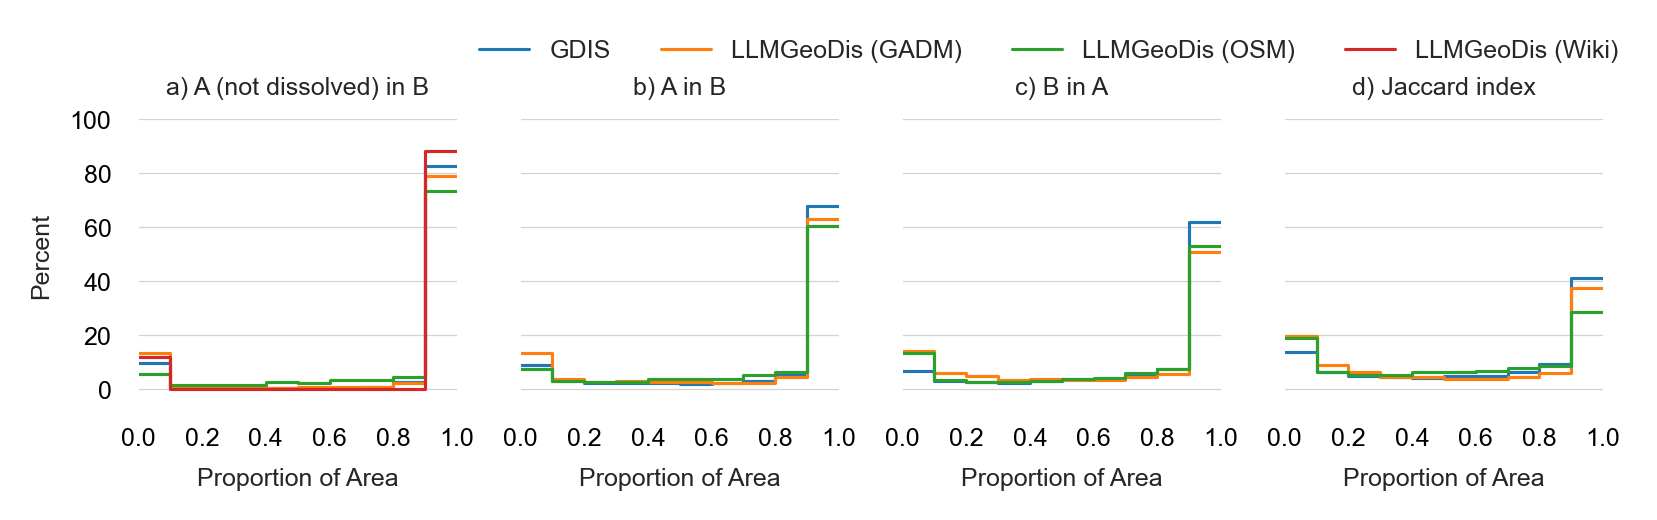

In [19]:
fig_row = {
    'GAUL': 0,
    'GDIS': 1
}

histplot_kwargs = {
    'element': 'step',
    'fill': False,
    'bins': BINS,
    'stat': 'percent',
    'linewidth': 0.75
}

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True,
                         figsize=(16 / 2.54, 3 / 2.54))

for source, benchmark in combinations_gaul:
    [ax0, ax1, ax2, ax3] = axes  #[fig_row[benchmark], :]
    ax0.set_title("a) A (not dissolved) in B")  #(f"{benchmark} (a in b)")
    ax1.set_title("b) A in B")  #(f"{benchmark} (a in b)")
    ax2.set_title("c) B in A")  #(f"{benchmark} (b in a)")
    ax3.set_title("d) Jaccard index")  #(f"{benchmark} (Jaccard)")

    subset_data = output_data[(output_data['geom_type_a'] == source) & (
            output_data['geom_type_b'] == benchmark)]
    subset_data_dissolved = output_data_dissolved[
        (output_data_dissolved['geom_type_a'] == source) & (
                output_data_dissolved['geom_type_b'] == benchmark)]
    # print(f"{source} vs {benchmark}")
    # print(subset_data.head())

    sns.histplot(data=subset_data, x='a_in_b', ax=ax0, label=f'{source}',
                 **histplot_kwargs)  #(n={len(subset_data):,})
    if source != 'LLMGeoDis (Wiki)':
        sns.histplot(data=subset_data_dissolved, x='a_in_b', ax=ax1,
                     label=f'{source}',
                     **histplot_kwargs)  # (n={len(subset_data_dissolved):,})
        sns.histplot(data=subset_data_dissolved, x='b_in_a', ax=ax2,
                     label=f'{source}',
                     **histplot_kwargs)  # (n={len(subset_data_dissolved):,})
        sns.histplot(data=subset_data_dissolved, x='jaccard', ax=ax3,
                     label=f'{source}',
                     **histplot_kwargs)  # (n={len(subset_data_dissolved):,})


def _format_ax(ax):
    ax.yaxis.set_major_locator(MultipleLocator(20))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.xaxis.set_major_locator(MultipleLocator(.20))
    ax.xaxis.set_minor_locator(MultipleLocator(.10))
    ax.grid(which='major', axis='y', linestyle='-', linewidth=.3,
            color='lightgrey')
    ax.set_ylim((-1, 100))
    ax.set_xlim((0, 1))
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_position(('outward', 2))
    ax.set(xlabel="Proportion of Area")
    return ax


for ax in axes.flatten():
    _format_ax(ax)
ax0.legend(loc='center left', ncol=4, title=None, frameon=False,
           bbox_to_anchor=(1, 1.25))

## Regional analysis
Summarize percent of high-overlap cases (>= 0.9) by region for `a_in_b` and `jaccard`.


C:\Users\dadelforge\AppData\Local\Temp\ipykernel_16532\1468400952.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_regions = pd.concat([results_regions, pd.DataFrame(


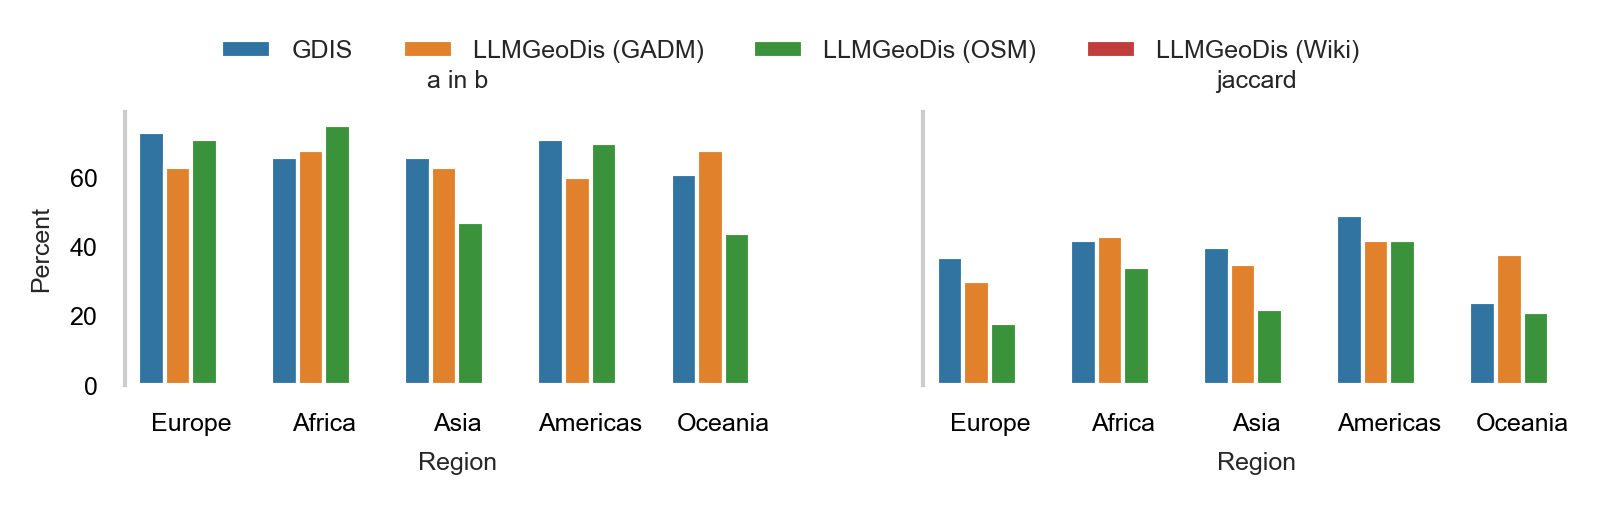

In [20]:
# Quick regional analysis
regions = output_data["Region"].unique()

results_regions = pd.DataFrame(columns=["Region", "a_in_b", "jaccard"])
for source, benchmark in combinations_gaul:
    subset_data_dissolved = output_data_dissolved[
        (output_data_dissolved['geom_type_a'] == source) & (
                output_data_dissolved['geom_type_b'] == benchmark)]
    for region in regions:
        region_filter = subset_data_dissolved["Region"] == region
        a_in_b = round(sum(
            subset_data_dissolved.loc[region_filter, "a_in_b"] >= 0.9) / sum(
            subset_data_dissolved.loc[region_filter, "a_in_b"] >= 0), 2) * 100
        jaccard = round(sum(
            subset_data_dissolved.loc[region_filter, "jaccard"] >= 0.9) / sum(
            subset_data_dissolved.loc[region_filter, "jaccard"] >= 0), 2) * 100

        results_regions = pd.concat([results_regions, pd.DataFrame(
            [[source, benchmark, region, a_in_b, jaccard]],
            columns=["a", "b", "Region", "a_in_b", "jaccard"])])

fig, [ax1, ax2] = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=(16 / 2.54, 3 / 2.54))
sns.barplot(data=results_regions, x="Region", y="a_in_b", hue="a", ax=ax1)
ax1.set(ylabel="Percent", title="a in b")

sns.barplot(data=results_regions, x="Region", y="jaccard", hue="a", ax=ax2,
            legend="")
ax2.set(ylabel="Percent", title="jaccard")

sns.move_legend(
    ax1, "lower center",
    bbox_to_anchor=(1, 1.1), ncol=4, title=None, frameon=False,
)

## Yearly analysis
Summarize percent of high-overlap cases (>= 0.9) by year for `a_in_b` and `jaccard`.


C:\Users\dadelforge\AppData\Local\Temp\ipykernel_16532\42917382.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_years = pd.concat([results_years, pd.DataFrame(


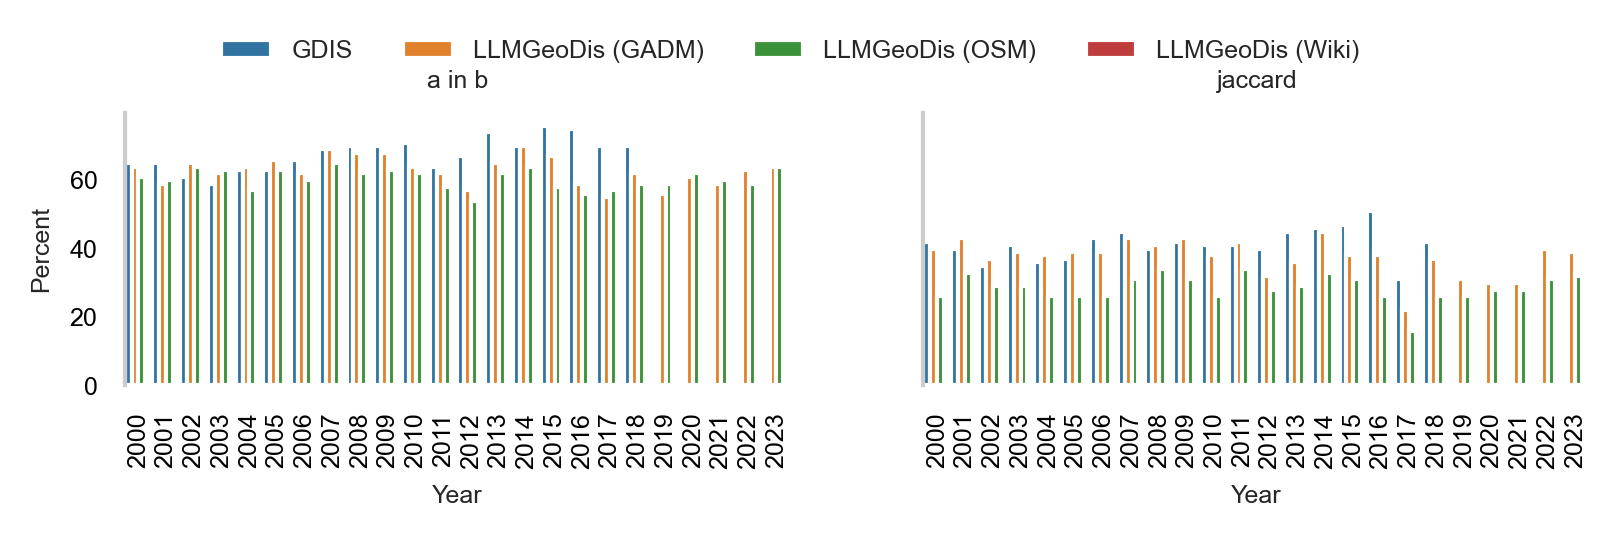

In [21]:
years = output_data["Start Year"].unique()
results_years = pd.DataFrame(columns=["Year", "a_in_b", "jaccard"])
for source, benchmark in combinations_gaul:
    subset_data_dissolved = output_data_dissolved[
        (output_data_dissolved['geom_type_a'] == source) & (
                output_data_dissolved['geom_type_b'] == benchmark)]
    for year in years:
        year_filter = subset_data_dissolved["Start Year"] == year
        a_in_b = round(
            sum(subset_data_dissolved.loc[year_filter, "a_in_b"] >= 0.9) / max(
                sum(subset_data_dissolved.loc[year_filter, "a_in_b"] >= 0),
                0.00001), 2) * 100
        jaccard = round(
            sum(subset_data_dissolved.loc[year_filter, "jaccard"] >= 0.9) / max(
                sum(subset_data_dissolved.loc[year_filter, "jaccard"] >= 0),
                0.0001), 2) * 100

        results_years = pd.concat([results_years, pd.DataFrame(
            [[source, benchmark, year, a_in_b, jaccard]],
            columns=["a", "b", "Year", "a_in_b", "jaccard"])])
results_years

fig, [ax1, ax2] = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=(16 / 2.54, 3 / 2.54))
sns.barplot(data=results_years, x="Year", y="a_in_b", hue="a", ax=ax1, width=1)
ax1.set(ylabel="Percent", title="a in b")
ax1.tick_params(axis='x', rotation=90)

sns.barplot(data=results_years, x="Year", y="jaccard", hue="a", ax=ax2, width=1,
            legend="")
ax2.set(ylabel="Percent", title="jaccard")
ax2.tick_params(axis='x', rotation=90)

sns.move_legend(
    ax1, "lower center",
    bbox_to_anchor=(1, 1.1), ncol=4, title=None, frameon=False,
)


## Disaster type analysis
Summarize percent of high-overlap cases (>= 0.9) by disaster type for `a_in_b` and `jaccard`.


C:\Users\dadelforge\AppData\Local\Temp\ipykernel_16532\489812052.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_disaster_types = pd.concat([results_disaster_types,


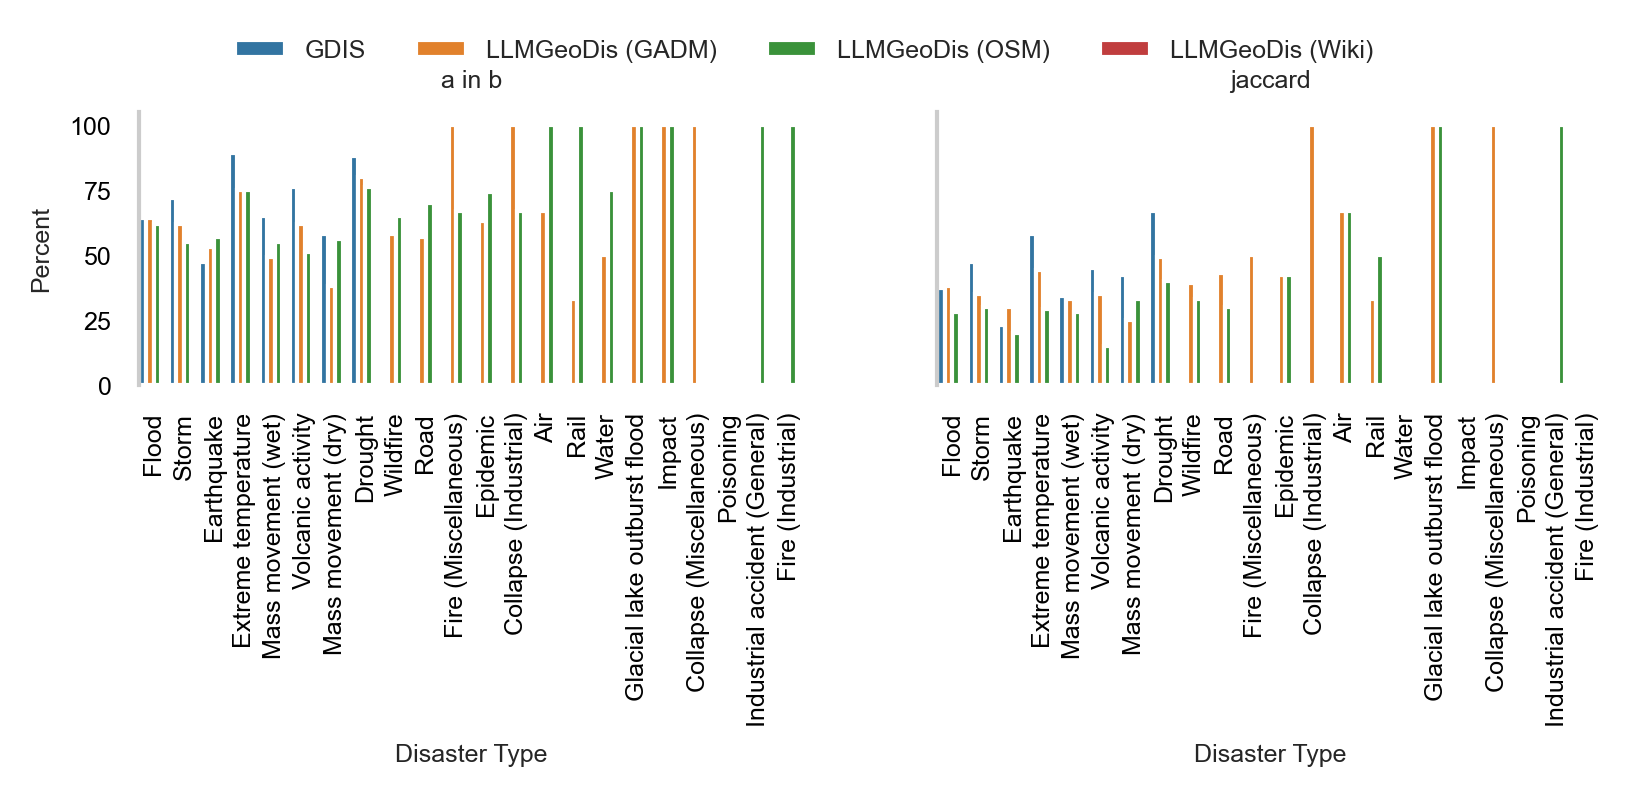

In [22]:
disaster_types = output_data["Disaster Type"].unique()
results_disaster_types = pd.DataFrame(
    columns=["Disaster Type", "a_in_b", "jaccard"])
for source, benchmark in combinations_gaul:
    subset_data_dissolved = output_data_dissolved[
        (output_data_dissolved['geom_type_a'] == source) & (
                output_data_dissolved['geom_type_b'] == benchmark)]
    for disaster_type in disaster_types:
        disaster_type_filter = subset_data_dissolved[
                                   "Disaster Type"] == disaster_type
        a_in_b = round(sum(subset_data_dissolved.loc[
                               disaster_type_filter, "a_in_b"] >= 0.9) / max(
            sum(subset_data_dissolved.loc[disaster_type_filter, "a_in_b"] >= 0),
            0.00001), 2) * 100
        jaccard = round(sum(subset_data_dissolved.loc[
                                disaster_type_filter, "jaccard"] >= 0.9) / max(
            sum(subset_data_dissolved.loc[
                    disaster_type_filter, "jaccard"] >= 0), 0.0001), 2) * 100

        results_disaster_types = pd.concat([results_disaster_types,
                                            pd.DataFrame([[source, benchmark,
                                                           disaster_type,
                                                           a_in_b, jaccard]],
                                                         columns=["a", "b",
                                                                  "Disaster Type",
                                                                  "a_in_b",
                                                                  "jaccard"])])

fig, [ax1, ax2] = plt.subplots(1, 2, sharex=True, sharey=True,
                               figsize=(16 / 2.54, 3 / 2.54))
sns.barplot(data=results_disaster_types, x="Disaster Type", y="a_in_b", hue="a",
            ax=ax1, width=1)
ax1.set(ylabel="Percent", title="a in b")
ax1.tick_params(axis='x', rotation=90)

sns.barplot(data=results_disaster_types, x="Disaster Type", y="jaccard",
            hue="a", ax=ax2, width=1, legend="")
ax2.set(ylabel="Percent", title="jaccard")
ax2.tick_params(axis='x', rotation=90)

sns.move_legend(
    ax1, "lower center",
    bbox_to_anchor=(1, 1.1), ncol=4, title=None, frameon=False,
)
